# 2.0 Pose Dimension Calculator

The `PoseDimensionCalculator` class operates through a series of algorithmic steps to calculate dimensions and angles based on pose data. Here's a technical breakdown of its key functions and the formulas used:

1. `enhance_pose_landmarks()`:  This method refines the pose data by creating additional landmark points to represent key body parts more accurately. It approximates the spine's location using the average coordinates of the torso's four landmarks (head, chest, stomach, and hips) and simplifies hand landmarks by averaging the coordinates of the pinky and index fingers to estimate the central position of the knuckles.
2. `calculate_pose_distance()` & `calculate_distances()`: This method calculates the physical distances between two joints. A smaller distance means a closer contact. elbow to knuckles.
3. `calculate_pose_angle()` & `calculate_connected_joint_range()`: These methods use `arctan2` to compute the angle between two vectors (connected joints based on human anatomy).
4. `calculate_rate_of_change()`: The method calculates the per-second rate of change of distances.

Concepts:
* Eucleandian Distance: https://science.howstuffworks.com/math-concepts/distance-formula.htm
* Atan2: https://en.wikipedia.org/wiki/Atan2
* Velocity: https://en.wikipedia.org/wiki/Velocity

### Implementation

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode

class PoseDimensionCalculator:
    
    def __init__(self, data, is_video=False):
        self.data = data
        
        self.enhance_pose_landmarks = self.enhance_pose_landmarks()
        self.data = self.enhance_pose_landmarks

        distances = self.calculate_distances()
        self.data = pd.concat([self.data, distances], axis=1)
        
        angles = self.calculate_connected_joint_range()
        self.data = pd.concat([self.data, angles], axis=1)

        if is_video:
            merged_data = self.calculate_rate_of_change()
            self.data = merged_data
    

    def enhance_pose_landmarks(self):
        enhanced_data = []
        for index, row in self.data.iterrows():
            enhanced_row = self.process_row(row)
            enhanced_row['index'] = index
            enhanced_data.append(enhanced_row)
        enhanced_df = pd.DataFrame(enhanced_data).set_index('index')  # Set the index of the DataFrame
        merged = pd.concat([self.data, enhanced_df], axis=1)  # Merge with the original DataFrame
        return merged

    def process_row(self, row):
        x_cols = sorted([col for col in self.data.columns if col.endswith('_x')])
        y_cols = sorted([col for col in self.data.columns if col.endswith('_y')])
        z_cols = sorted([col for col in self.data.columns if col.endswith('_z')])
        
        x = row[x_cols].values
        y = row[y_cols].values
        z = row[z_cols].values

        enhanced_row = {
            
            'head_x': x[0:10].mean(),
            'head_y': y[0:10].mean(),
            'head_z': z[0:10].mean(),
            'chest_x': x[11:13].mean(),
            'chest_y': y[11:13].mean(), 
            'chest_z': z[11:13].mean(),
            'stomach_x': (x[11:13].mean() + x[23:24].mean()) / 2,
            'stomach_y': (y[11:13].mean() + y[23:24].mean()) / 2,
            'stomach_z': (z[11:13].mean() + z[23:24].mean()) / 2,
            'hip_x': x[23:25].mean(),
            'hip_y': y[23:25].mean(),
            'hip_z': z[23:25].mean(),
            'knuckles_right_x': (x[18] + x[20])/2,
            'knuckles_right_y': (y[18] + y[20])/2,
            'knuckles_right_z': (z[18] + z[20])/2,
            'knuckles_left_x': (x[17] + x[19])/2,
            'knuckles_left_y': (y[17] + y[19])/2,
            'knuckles_left_z': (z[17] + z[19])/2,
        }

        return enhanced_row

    def calculate_pose_distance(self, Ax, Ay, Bx, By):
        distance = np.sqrt((self.data[Ax] - self.data[Bx])**2 + (self.data[Ay] - self.data[By])**2)
        return np.round(distance, 4)

    def calculate_distances(self):
        dist = pd.DataFrame(index=self.data.index)
        dist['dist_head_to_rgt_knee'] = self.calculate_pose_distance('head_x', 'head_y', 'landmark_26_x', 'landmark_26_y')
        dist['dist_head_to_lft_knee'] = self.calculate_pose_distance('head_x', 'head_y', 'landmark_25_x', 'landmark_25_y')
        dist['dist_head_to_rgt_ankle'] = self.calculate_pose_distance('head_x', 'head_y', 'landmark_28_x', 'landmark_28_y')
        dist['dist_head_to_lft_ankle'] = self.calculate_pose_distance('head_x', 'head_y', 'landmark_27_x', 'landmark_27_y')
        dist['dist_rgt_shoulder_to_wrist'] = self.calculate_pose_distance('landmark_12_x', 'landmark_12_y', 'landmark_16_x', 'landmark_16_y')
        dist['dist_lft_shoulder_to_wrist'] = self.calculate_pose_distance('landmark_11_x', 'landmark_11_y', 'landmark_15_x', 'landmark_15_y')
        dist['dist_rgt_shoulder_to_knee'] = self.calculate_pose_distance('landmark_12_x', 'landmark_12_y', 'landmark_26_x', 'landmark_26_y')
        dist['dist_lft_shoulder_to_knee'] = self.calculate_pose_distance('landmark_11_x', 'landmark_11_y', 'landmark_25_x', 'landmark_25_y')
        dist['dist_rgt_elbow_to_hip'] = self.calculate_pose_distance('landmark_14_x', 'landmark_14_y', 'landmark_24_x', 'landmark_24_y')
        dist['dist_lft_elbow_to_hip'] = self.calculate_pose_distance('landmark_13_x', 'landmark_13_y', 'landmark_23_x', 'landmark_23_y')        
        dist['dist_rgt_hip_to_wrist'] = self.calculate_pose_distance('landmark_24_x', 'landmark_24_y', 'landmark_16_x', 'landmark_16_y')
        dist['dist_lft_hip_to_wrist'] = self.calculate_pose_distance('landmark_23_x', 'landmark_23_y', 'landmark_15_x', 'landmark_15_y')
        dist['dist_bet_wrists'] = self.calculate_pose_distance('landmark_16_x', 'landmark_16_y', 'landmark_15_x', 'landmark_15_y')
        dist['dist_bet_elbows'] = self.calculate_pose_distance('landmark_14_x', 'landmark_14_y', 'landmark_13_x', 'landmark_13_y')
        dist['dist_bet_knees'] = self.calculate_pose_distance('landmark_26_x', 'landmark_26_y', 'landmark_25_x', 'landmark_25_y')
        dist['dist_bet_ankles'] = self.calculate_pose_distance('landmark_28_x', 'landmark_28_y', 'landmark_27_x', 'landmark_27_y')
        
        return dist

    def calculate_pose_angle(self, Ax, Ay, Bx, By, Cx, Cy):
        A = self.data[[Ax, Ay]].values
        B = self.data[[Bx, By]].values
        C = self.data[[Cx, Cy]].values
        BA = A - B
        BC = C - B
        angle_BA = np.arctan2(BA[:, 1], BA[:, 0])
        angle_BC = np.arctan2(BC[:, 1], BC[:, 0])
        angle_difference = np.degrees(angle_BC - angle_BA)    
        return np.round(angle_difference, 4)
        
    def calculate_connected_joint_range(self):
        
        angles = pd.DataFrame(index=self.data.index)
        
        angles['a_head_to_stomach'] = self.calculate_pose_angle('head_x', 'head_y', 'chest_x', 'chest_y','stomach_x','stomach_y')
        angles['a_chest_to_hip'] = self.calculate_pose_angle('chest_x', 'chest_y', 'stomach_x', 'stomach_y','hip_x','hip_y')
        angles['a_mid_hip_to_knees'] = self.calculate_pose_angle('landmark_26_x','landmark_26_y','hip_x', 'hip_y','landmark_25_x','landmark_25_y')
        angles['a_rgt_shoulder_to_wrist'] = self.calculate_pose_angle('landmark_12_x', 'landmark_12_y', 'landmark_14_x', 'landmark_14_y', 'landmark_16_x', 'landmark_16_y')
        angles['a_rgt_elbow_to_knuckles'] = self.calculate_pose_angle('landmark_14_x', 'landmark_14_y', 'landmark_16_x', 'landmark_16_y', 'knuckles_right_x', 'knuckles_right_y')               
        angles['a_rgt_thumb_to_knuckles'] = self.calculate_pose_angle('landmark_22_x', 'landmark_22_y', 'landmark_18_x', 'landmark_18_y', 'knuckles_right_x', 'knuckles_right_y')       
        angles['a_rgt_shoulder_to_knee'] = self.calculate_pose_angle('landmark_12_x', 'landmark_12_y', 'landmark_24_x', 'landmark_24_y','landmark_26_x', 'landmark_26_y')
        angles['a_rgt_hip_to_foot'] = self.calculate_pose_angle('landmark_24_x', 'landmark_24_y', 'landmark_26_x', 'landmark_26_y','landmark_28_x', 'landmark_28_y')
        angles['a_rgt_foot_to_ankle'] = self.calculate_pose_angle('landmark_26_x', 'landmark_26_y', 'landmark_28_x', 'landmark_28_y','landmark_32_x', 'landmark_32_y')
        angles['a_lft_shoulder_to_wrist'] = self.calculate_pose_angle('landmark_11_x', 'landmark_11_y', 'landmark_13_x', 'landmark_13_y', 'landmark_15_x', 'landmark_15_y')
        angles['a_lft_elbow_to_knuckles'] = self.calculate_pose_angle('landmark_13_x', 'landmark_13_y', 'landmark_15_x', 'landmark_15_y', 'knuckles_left_x', 'knuckles_left_y')               
        angles['a_lft_thumb_to_knuckles'] = self.calculate_pose_angle('landmark_21_x', 'landmark_21_y', 'landmark_17_x', 'landmark_17_y', 'knuckles_left_x', 'knuckles_left_y')       
        angles['a_lft_shoulder_to_knee'] = self.calculate_pose_angle('landmark_11_x', 'landmark_11_y', 'landmark_23_x', 'landmark_23_y','landmark_25_x', 'landmark_25_y')
        angles['a_lft_hip_to_foot'] = self.calculate_pose_angle('landmark_23_x', 'landmark_23_y', 'landmark_25_x', 'landmark_25_y','landmark_27_x', 'landmark_27_y')
        angles['a_lft_foot_to_ankle'] = self.calculate_pose_angle('landmark_25_x', 'landmark_25_y', 'landmark_27_x', 'landmark_27_y','landmark_31_x', 'landmark_31_y')
        
        return angles
        
    def calculate_rate_of_change(self):
        secs_counts = self.data.groupby('secs').size()
        fps = secs_counts.max()

        d_cols = sorted([col for col in self.data.columns if col.startswith('dist_')])

        grouped_data = self.data.groupby('secs')[d_cols].mean()
        roc_data = pd.DataFrame(index=grouped_data.index)
        
        for col in d_cols:
            differences = grouped_data[col].diff().fillna(0)
            roc_data[f'r_{col}'] = differences * fps
            
        merged_data = pd.merge(self.data, roc_data, on='secs', how='left')
        return merged_data

# Sample Usage

In [77]:
internal_files_dir = ['data/ground_truth/processed/upright/',
                      'data/ground_truth/processed/combined/']

for dir in internal_files_dir:
    source_filepath = dir + "pose_data_raw.csv"
    save_filepath = dir + "pose_data2.csv"    
    
    pose_df = pd.read_csv(source_filepath)
    pose_rs = PoseDimensionCalculator(pose_df, is_video=True)
    pose_rs.data.to_csv(save_filepath, index=False)

pose_rs.data

,image_filename,secs,frame_no,landmark_00_x,landmark_00_y,landmark_00_z,landmark_00_v,landmark_01_x,landmark_01_y,landmark_01_z,...,r_dist_head_to_rgt_ankle,r_dist_head_to_rgt_knee,r_dist_lft_elbow_to_hip,r_dist_lft_hip_to_wrist,r_dist_lft_shoulder_to_knee,r_dist_lft_shoulder_to_wrist,r_dist_rgt_elbow_to_hip,r_dist_rgt_hip_to_wrist,r_dist_rgt_shoulder_to_knee,r_dist_rgt_shoulder_to_wrist
0,0000_00000000.png,0,0,0.344036,0.396791,-0.201429,0.999840,0.336918,0.392906,-0.179947,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0000_00000006.png,0,6,0.359137,0.398735,-0.098929,0.999088,0.352957,0.394336,-0.080911,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0000_00000012.png,0,12,0.372587,0.405103,-0.107498,0.999276,0.369313,0.401648,-0.095157,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0000_00000018.png,0,18,0.373569,0.406002,-0.064166,0.998054,0.370616,0.402092,-0.051283,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0000_00000024.png,0,24,0.374824,0.407847,-0.046187,0.987026,0.371738,0.403893,-0.034450,...,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0039_00001170.png,39,1170,0.606066,0.409517,-0.044457,1.000000,0.602062,0.404425,-0.023998,...,0.0097,-0.0977,-0.136,-0.0402,-0.0535,0.0919,-0.1947,-0.0964,-0.0526,0.1292
182,0039_00001176.png,39,1176,0.606475,0.414142,-0.062554,0.999998,0.605433,0.409361,-0.039426,...,0.0097,-0.0977,-0.136,-0.0402,-0.0535,0.0919,-0.1947,-0.0964,-0.0526,0.1292
183,0039_00001182.png,39,1182,0.607203,0.415867,-0.039507,0.999997,0.606267,0.410935,-0.018027,...,0.0097,-0.0977,-0.136,-0.0402,-0.0535,0.0919,-0.1947,-0.0964,-0.0526,0.1292
184,0039_00001188.png,39,1188,0.606418,0.415987,-0.059404,0.999999,0.605840,0.411162,-0.038295,...,0.0097,-0.0977,-0.136,-0.0402,-0.0535,0.0919,-0.1947,-0.0964,-0.0526,0.1292


In [78]:
internal_files_dir = ['data/internal/tricks/', 'data/internal/positions/body/', 'data/internal/positions/grip/', 'data/internal/positions/legs/']

for dir in internal_files_dir:
    source_filepath = dir + "pose_data_raw.csv"
    save_filepath = dir + "pose_data2.csv"    
    pose_df = pd.read_csv(source_filepath)
    pose_rs = PoseDimensionCalculator(pose_df, is_video=False)
    pose_rs.data.to_csv(save_filepath, index=False)

## 2.1 Pose Dimension Visualization

Heights and angles are visualized for quick inspection.

In [57]:
data = pd.read_csv('data/internal/tricks/pose_data.csv')
data

,image_filename,pose_name,landmark_00_x,landmark_00_y,landmark_00_z,landmark_00_v,landmark_01_x,landmark_01_y,landmark_01_z,landmark_01_v,...,a_rgt_thumb_to_knuckles,a_rgt_shoulder_to_knee,a_rgt_hip_to_foot,a_rgt_foot_to_ankle,a_lft_shoulder_to_wrist,a_lft_elbow_to_knuckles,a_lft_thumb_to_knuckles,a_lft_shoulder_to_knee,a_lft_hip_to_foot,a_lft_foot_to_ankle
0,advanced-figurehead-lft.png,advanced-figurehead-lft,0.545408,0.259078,-0.407526,0.998032,0.529543,0.271390,-0.377108,0.997484,...,35.3069,217.3471,-98.4931,-193.7909,-276.8157,-191.9330,28.5721,214.3840,-102.7408,-191.1499
1,advanced-figurehead-rgt.png,advanced-figurehead-rgt,0.436167,0.272993,0.042864,0.994189,0.451747,0.284805,0.008824,0.993863,...,-30.9653,143.4659,107.3156,-172.3374,-70.6368,-173.7165,-34.2730,146.6870,96.1283,-169.0750
2,aerial-leg-hold-crucifix-lft.png,aerial-leg-hold-crucifix-lft,0.504749,0.180154,-0.839282,0.999996,0.512618,0.166645,-0.803643,0.999990,...,-142.7568,189.3511,154.8557,176.5699,169.2824,-176.5266,140.8909,176.4368,174.2972,195.0818
3,aerial-leg-hold-crucifix-rgt.png,aerial-leg-hold-crucifix-rgt,0.499891,0.180474,-0.591090,0.999997,0.509142,0.168015,-0.550916,0.999988,...,-129.9074,185.0975,179.9717,180.7875,170.7356,184.0058,128.3992,173.7934,202.3521,189.7082
4,air-walk-lft.png,air-walk-lft,0.450799,0.341594,-0.282800,0.999512,0.444959,0.327051,-0.349440,0.999634,...,-305.2952,222.3427,180.4206,-110.6382,156.8697,175.8126,38.6072,205.1717,170.3318,279.0266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,wrist-sit-rgt.png,wrist-sit-rgt,0.506111,0.534306,-0.154565,0.999970,0.509519,0.520750,-0.135237,0.999945,...,-2.8584,-1.3014,-185.4802,-190.4929,-185.5553,-182.1034,-326.6048,66.4931,-178.7115,-177.3025
550,yogini-lft.png,yogini-lft,0.750999,0.265975,0.050217,1.000000,0.734617,0.252835,0.082880,1.000000,...,43.1153,229.8720,-70.8528,-218.2939,187.0363,183.8311,93.3314,229.4455,-81.5335,-198.1528
551,yogini-rgt.png,yogini-rgt,0.254569,0.253966,0.185102,0.999985,0.276668,0.244936,0.168699,0.999988,...,-67.0513,132.5758,80.8230,-159.2451,173.0351,174.5970,-48.4027,133.5355,74.3108,-173.9775
552,yogini-twisted-lft.png,yogini-twisted-lft,0.356109,0.269642,-0.166786,0.999335,0.358961,0.250586,-0.201648,0.998349,...,-9.3961,271.1585,121.3195,203.7296,-182.1522,-157.8225,-106.9895,140.2172,66.5343,-168.5053


In [71]:
from helpers.data_visualization_utils import *

def visualize_pose_dimension_by_sec(source_image_dir, input_data, sec):
    data['secs'] = data['secs'].astype(int)
    filtered_data = data[data['secs'] == sec]
    
    row = filtered_data.iloc[0]

    focus_angles = {
        'Head->Stomach': (row['a_head_to_stomach'], row['head_x'], row['head_y'],row['chest_x'], row['chest_y'], row['stomach_x'], row['stomach_y']),
        'R.Shoulder->Wrist': (row['a_rgt_shoulder_to_wrist'], row['landmark_12_x'], row['landmark_12_y'],row['landmark_14_x'], row['landmark_14_y'], row['landmark_16_x'],row['landmark_16_y']),
        'R.Elbow->Knuckles': (row['a_rgt_elbow_to_knuckles'], row['landmark_14_x'],row['landmark_14_y'], row['landmark_16_x'], row['landmark_16_y'], row['knuckles_right_x'],row['knuckles_right_y']),
        'R.Foot->Ankle': (row['a_rgt_hip_to_foot'], row['landmark_24_x'], row['landmark_24_y'],row['landmark_26_x'], row['landmark_26_y'], row['landmark_28_x'],row['landmark_28_y']),
        'L.Shoulder->Wrist': (row['a_lft_shoulder_to_wrist'], row['landmark_11_x'], row['landmark_11_y'],row['landmark_13_x'], row['landmark_13_y'], row['landmark_15_x'],row['landmark_15_y']),
        'L.Elbow->Knuckles': (row['a_lft_elbow_to_knuckles'], row['landmark_13_x'],row['landmark_13_y'], row['landmark_15_x'], row['landmark_15_y'], row['knuckles_left_x'],row['knuckles_left_y']),
        'L.Foot->Ankle': (row['a_lft_hip_to_foot'], row['landmark_23_x'], row['landmark_23_y'],row['landmark_25_x'], row['landmark_26_y'], row['landmark_27_x'],row['landmark_27_y']),
    }

    focus_heights = {
        'Wrists': (row['dist_bet_wrists'], row['landmark_16_x'],row['landmark_16_y'],row['landmark_15_x'],row['landmark_15_y']),
    }   
    
    visualize_pose_dimension_lengths(source_image_dir, row, focus_heights)
    visualize_pose_dimension_angles(source_image_dir, row, focus_angles)

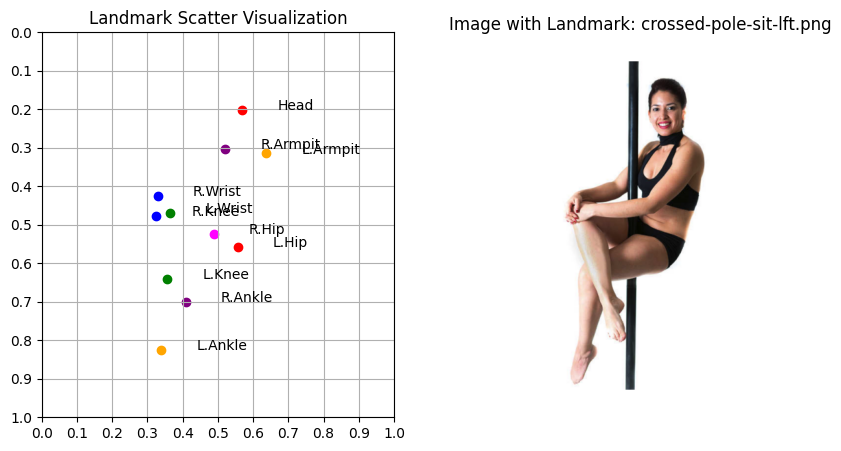

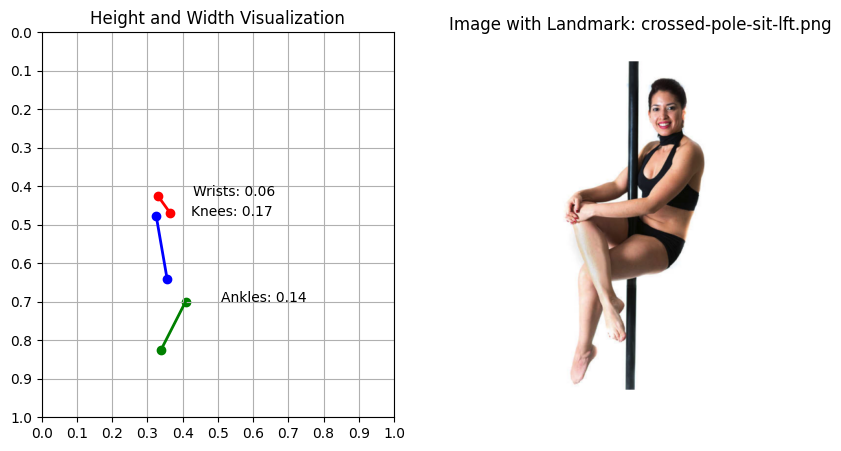

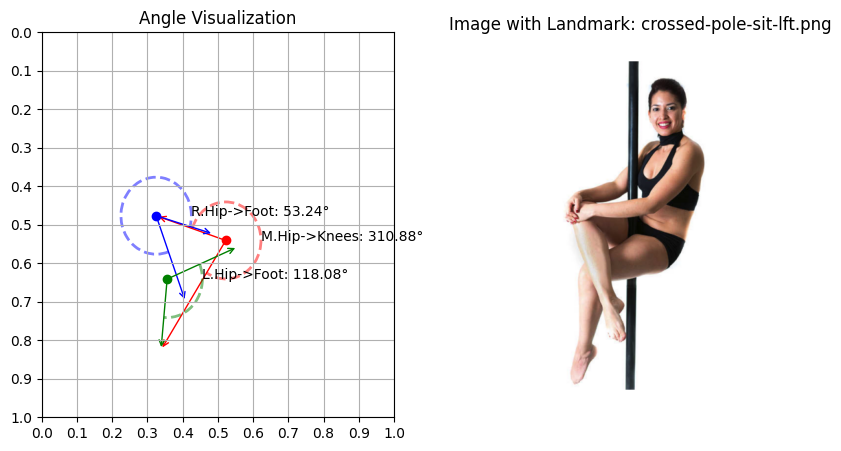

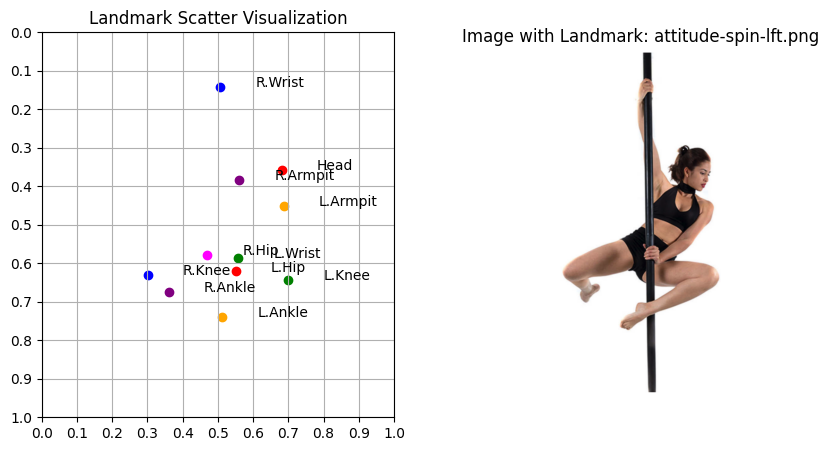

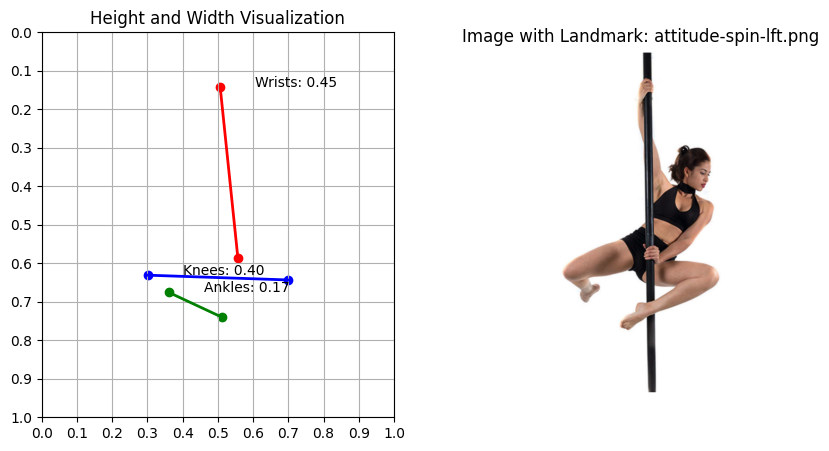

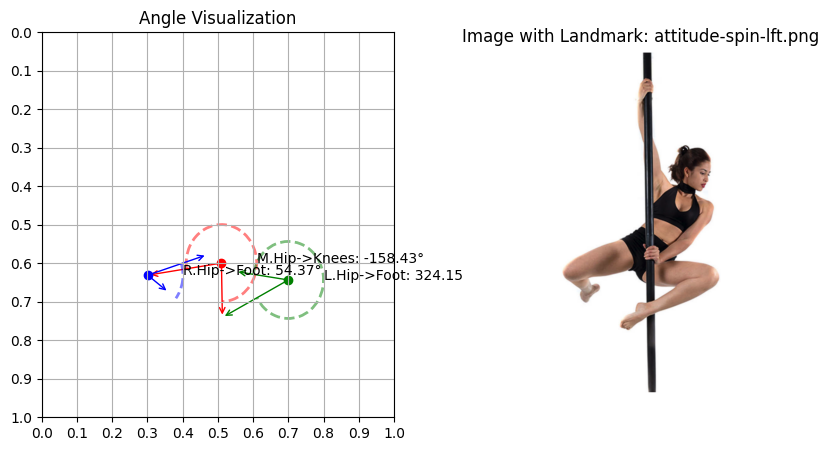

In [9]:
from helpers.data_visualization_utils import *

def visualize_pose_dimension_by_keyword(source_image_dir, input_data, keyword):
    filtered_data = data[data['pose_name'].str.startswith(keyword)]

    row = filtered_data.iloc[0]

    focus_landmarks = {
        'Head': (row['head_x'], row['head_y']),
        'R.Wrist': (row['landmark_16_x'], row['landmark_16_y']),
        'L.Wrist': (row['landmark_15_x'], row['landmark_15_y']),
        'R.Armpit': (row['landmark_12_x'], row['landmark_12_y']),
        'L.Armpit': (row['landmark_11_x'], row['landmark_11_y']),
        'R.Hip': (row['landmark_24_x'], row['landmark_24_y']),
        'L.Hip': (row['landmark_23_x'], row['landmark_23_y']),
        'R.Knee': (row['landmark_26_x'], row['landmark_26_y']),
        'L.Knee': (row['landmark_25_x'], row['landmark_25_y']),
        'R.Ankle': (row['landmark_28_x'], row['landmark_28_y']),
        'L.Ankle': (row['landmark_27_x'], row['landmark_27_y']),
    }
    
    focus_angles = {
        #'Head->Stomach': (row['a_head_to_stomach'], row['head_x'], row['head_y'],row['chest_x'], row['chest_y'], row['stomach_x'], row['stomach_y']),
        #'Chest->M.Hip': (row['a_chest_to_hip'], row['chest_x'], row['chest_y'],row['stomach_x'], row['stomach_y'], row['hip_x'], row['hip_y']),
        'M.Hip->Knees': (row['a_mid_hip_to_knees'], row['landmark_26_x'], row['landmark_26_y'],row['hip_x'], row['hip_y'], row['landmark_27_x'], row['landmark_27_y']),
        'R.Hip->Foot': (row['a_rgt_hip_to_foot'], row['landmark_24_x'], row['landmark_24_y'],row['landmark_26_x'], row['landmark_26_y'], row['landmark_28_x'], row['landmark_28_y']),
        'L.Hip->Foot': (row['a_lft_hip_to_foot'], row['landmark_23_x'], row['landmark_23_y'],row['landmark_25_x'], row['landmark_25_y'], row['landmark_27_x'], row['landmark_27_y']),
    }

    focus_heights = {
        #'Head->R.Ankle': (row['dist_head_to_rgt_ankle'], row['head_x'],row['head_y'],row['landmark_28_x'],row['landmark_28_y']),
        #'Head->L.Ankle': (row['dist_head_to_rgt_ankle'], row['head_x'],row['head_y'],row['landmark_27_x'],row['landmark_27_y']),
        'Wrists': (row['dist_bet_wrists'], row['landmark_16_x'],row['landmark_16_y'],row['landmark_15_x'],row['landmark_15_y']),
        'Knees': (row['dist_bet_knees'], row['landmark_26_x'],row['landmark_26_y'],row['landmark_25_x'],row['landmark_25_y']),
        'Ankles': (row['dist_bet_ankles'], row['landmark_28_x'],row['landmark_28_y'],row['landmark_27_x'],row['landmark_27_y']),
    }   


    visualize_pose_coordinates(source_image_dir, row, focus_landmarks)
    visualize_pose_dimension_lengths(source_image_dir, row, focus_heights)
    visualize_pose_dimension_angles(source_image_dir, row, focus_angles)

data = pd.read_csv('data/internal/tricks/pose_data.csv')
source_image_dir = 'data/internal/tricks/'

visualize_pose_dimension_by_keyword(source_image_dir, data, 'crossed')
visualize_pose_dimension_by_keyword(source_image_dir, data, 'attitude')

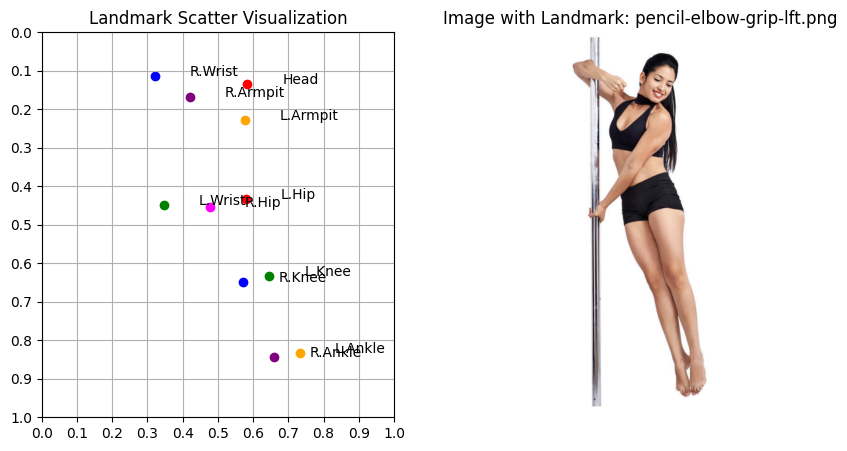

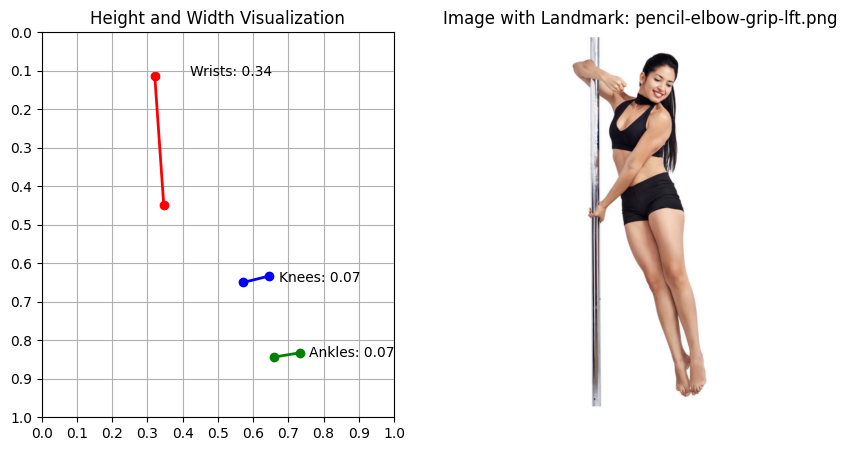

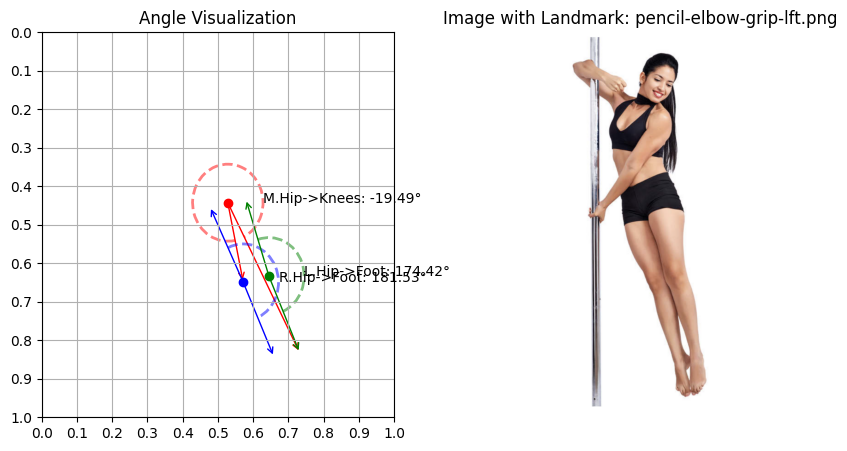

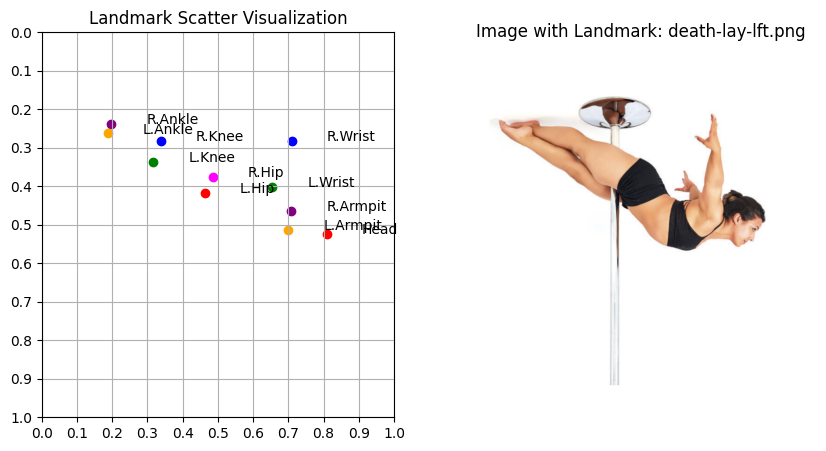

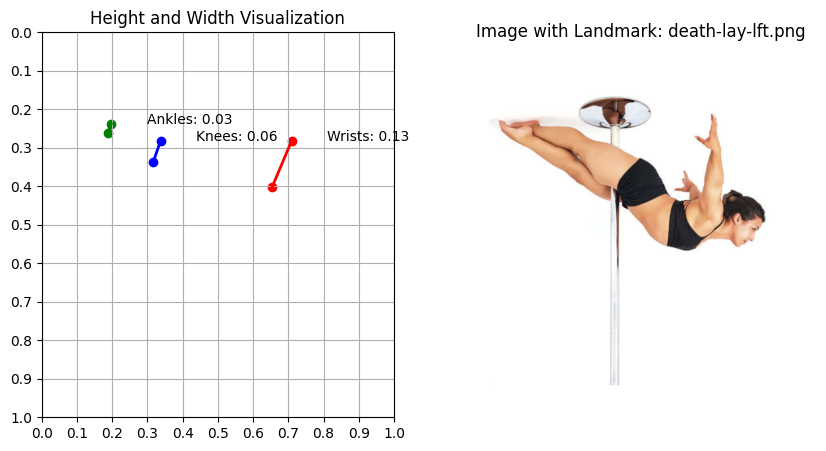

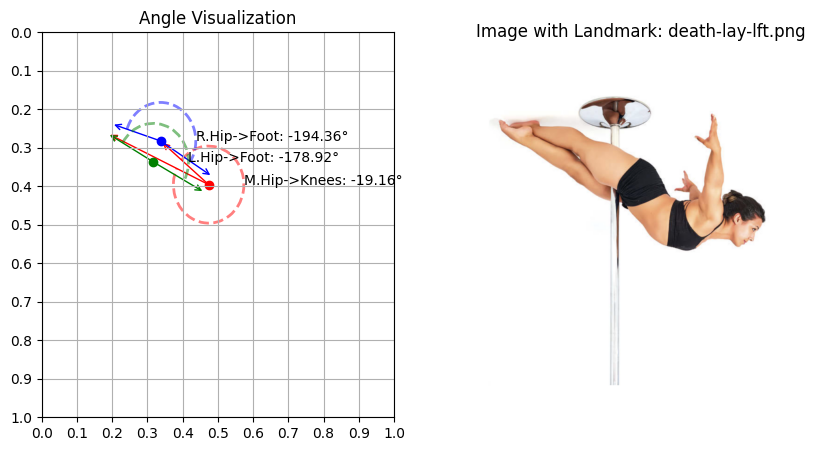

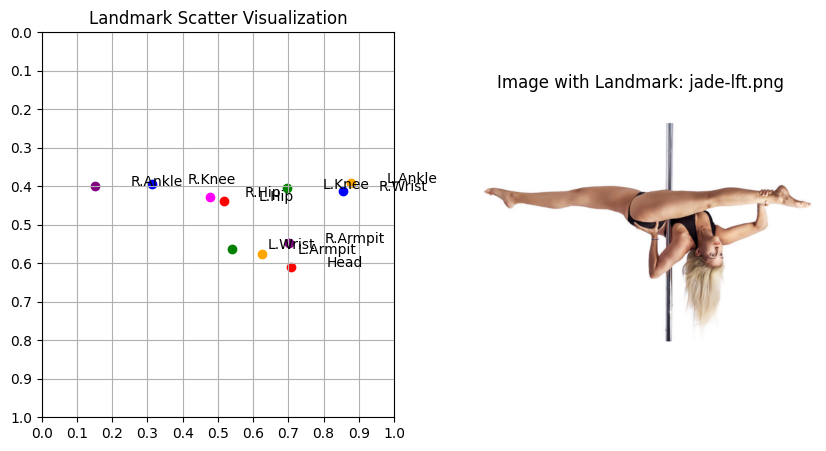

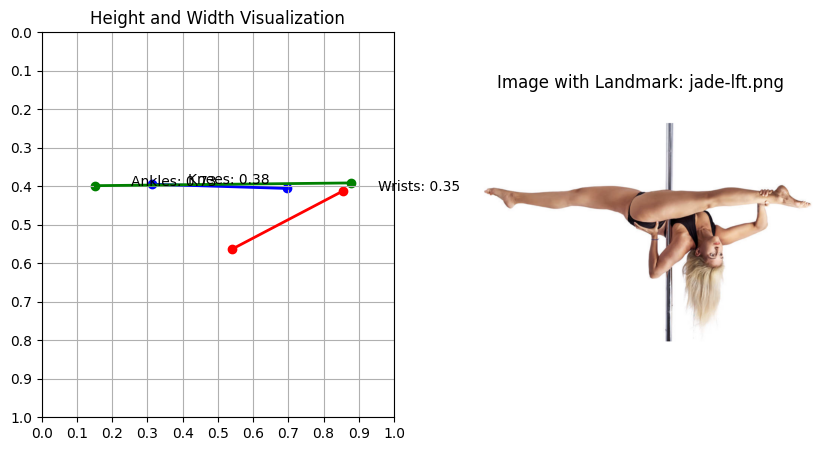

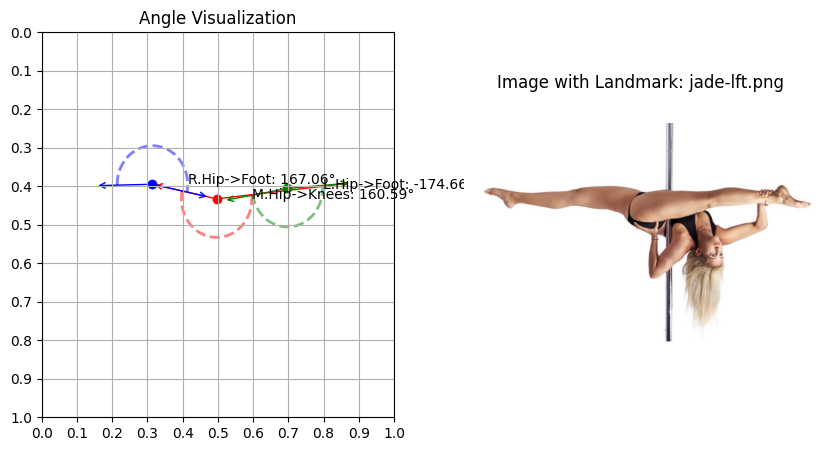

In [13]:
visualize_pose_dimension_by_keyword(source_image_dir, data, 'pencil')
visualize_pose_dimension_by_keyword(source_image_dir, data, 'death-lay')
visualize_pose_dimension_by_keyword(source_image_dir, data, 'jade')

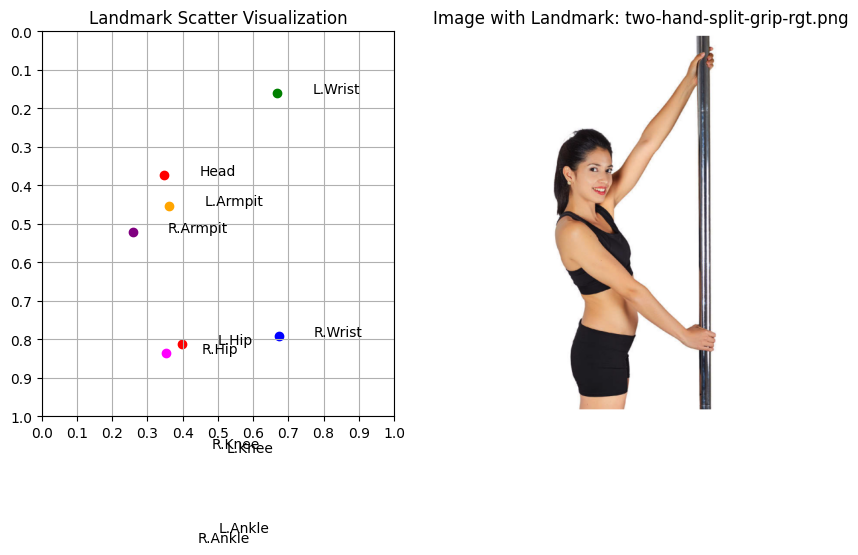

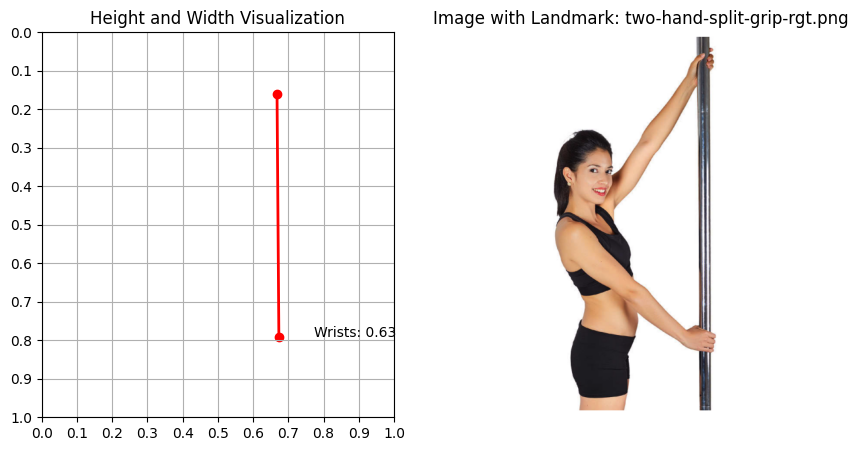

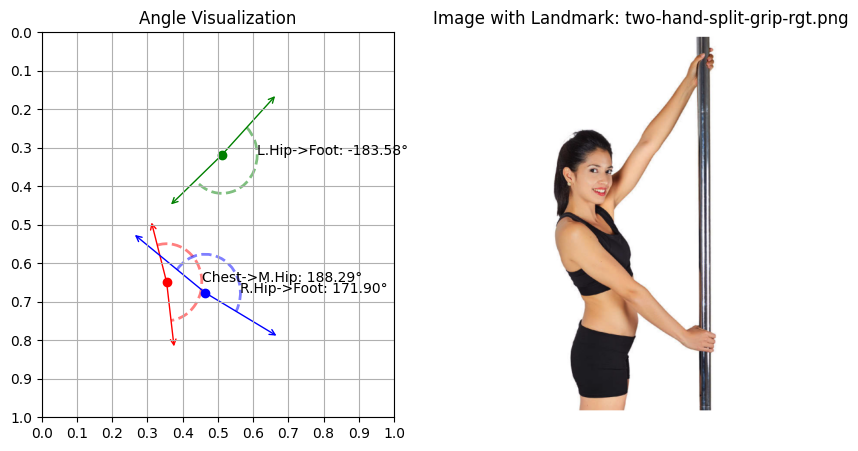

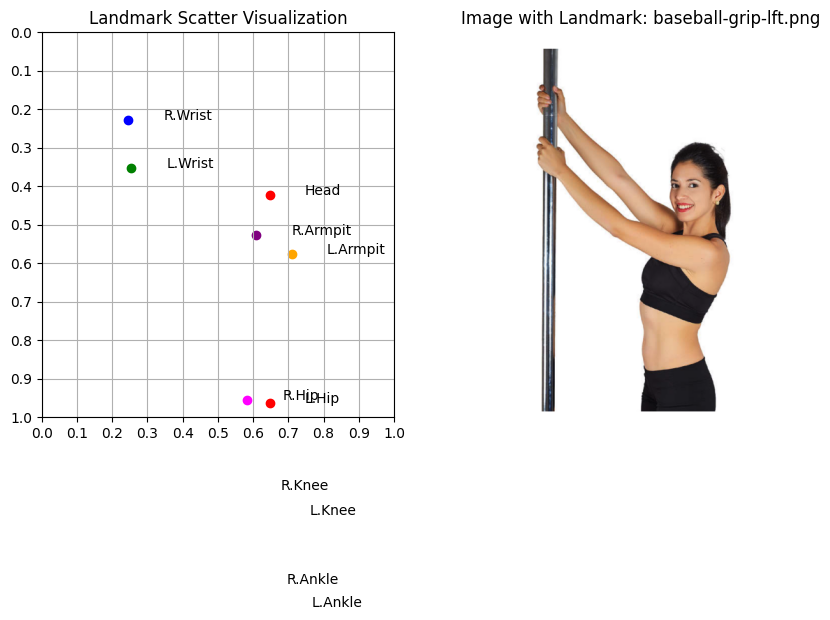

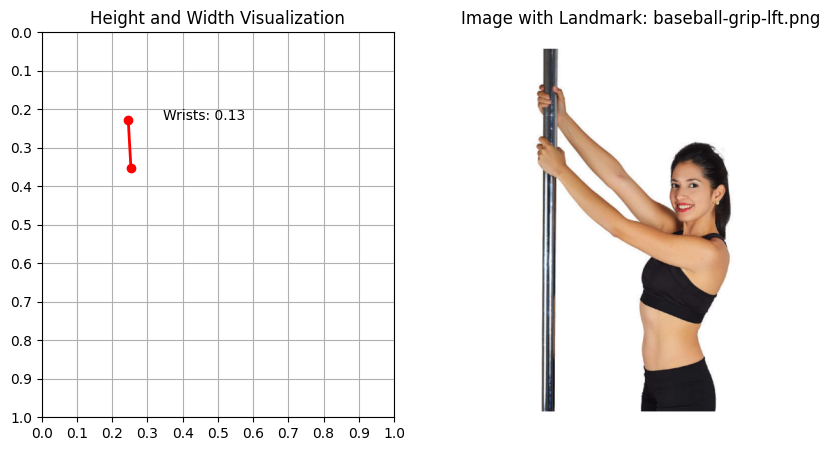

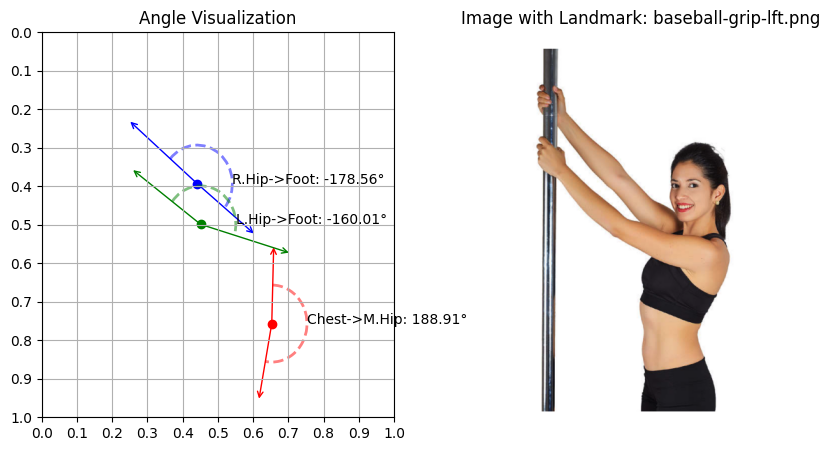

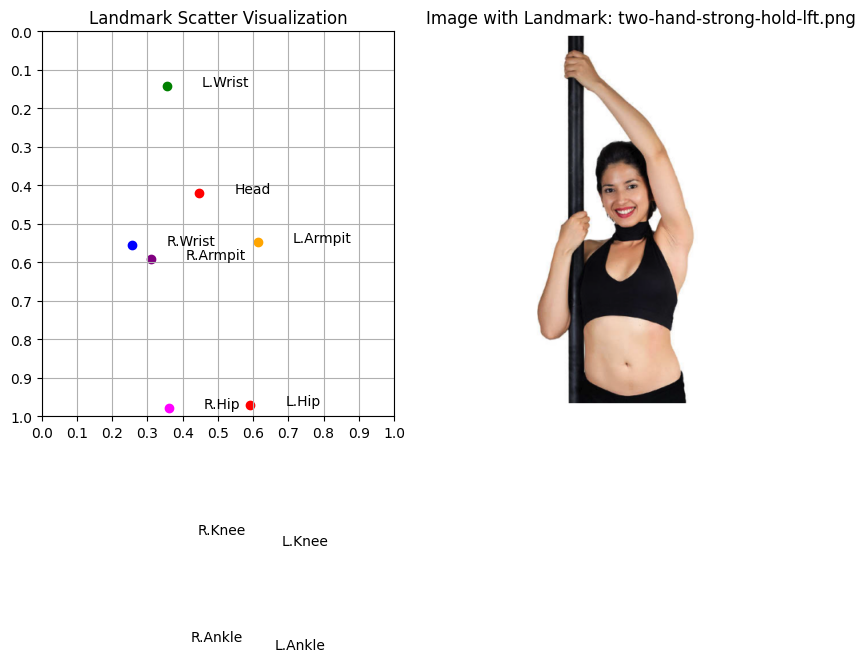

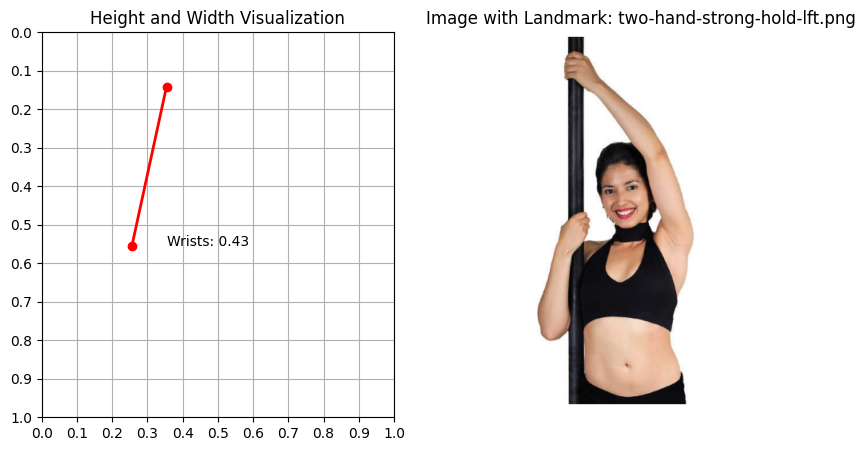

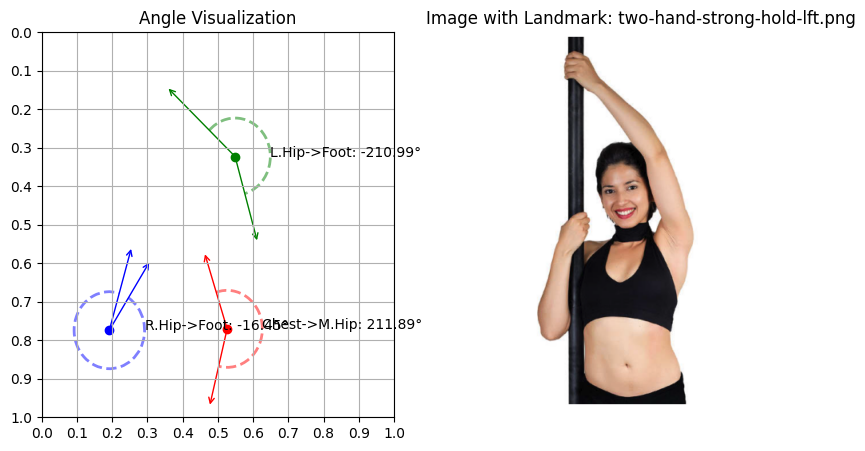

In [22]:
from helpers.data_visualization_utils import *

def visualize_pose_dimension_by_keyword(source_image_dir, input_data, keyword):
    filtered_data = data[data['pose_name'].str.startswith(keyword)]

    row = filtered_data.iloc[1]

    focus_landmarks = {
        'Head': (row['head_x'], row['head_y']),
        'R.Wrist': (row['landmark_16_x'], row['landmark_16_y']),
        'L.Wrist': (row['landmark_15_x'], row['landmark_15_y']),
        'R.Armpit': (row['landmark_12_x'], row['landmark_12_y']),
        'L.Armpit': (row['landmark_11_x'], row['landmark_11_y']),
        'R.Hip': (row['landmark_24_x'], row['landmark_24_y']),
        'L.Hip': (row['landmark_23_x'], row['landmark_23_y']),
        'R.Knee': (row['landmark_26_x'], row['landmark_26_y']),
        'L.Knee': (row['landmark_25_x'], row['landmark_25_y']),
        'R.Ankle': (row['landmark_28_x'], row['landmark_28_y']),
        'L.Ankle': (row['landmark_27_x'], row['landmark_27_y']),
    }
    
    focus_angles = {
        'Chest->M.Hip': (row['a_chest_to_hip'], row['chest_x'], row['chest_y'],row['stomach_x'], row['stomach_y'], row['hip_x'], row['hip_y']),
        'R.Hip->Foot': (row['a_rgt_shoulder_to_wrist'], row['landmark_12_x'], row['landmark_12_y'],row['landmark_14_x'], row['landmark_14_y'], row['landmark_16_x'], row['landmark_16_y']),
        'L.Hip->Foot': (row['a_lft_shoulder_to_wrist'], row['landmark_11_x'], row['landmark_11_y'],row['landmark_13_x'], row['landmark_13_y'], row['landmark_15_x'], row['landmark_15_y']),
    }

    focus_heights = {
        #'Head->R.Ankle': (row['dist_head_to_rgt_ankle'], row['head_x'],row['head_y'],row['landmark_28_x'],row['landmark_28_y']),
        #'Head->L.Ankle': (row['dist_head_to_rgt_ankle'], row['head_x'],row['head_y'],row['landmark_27_x'],row['landmark_27_y']),
        'Wrists': (row['dist_bet_wrists'], row['landmark_16_x'],row['landmark_16_y'],row['landmark_15_x'],row['landmark_15_y']),
        #'Knees': (row['dist_bet_knees'], row['landmark_26_x'],row['landmark_26_y'],row['landmark_25_x'],row['landmark_25_y']),
        #'Ankles': (row['dist_bet_ankles'], row['landmark_28_x'],row['landmark_28_y'],row['landmark_27_x'],row['landmark_27_y']),
    }   


    visualize_pose_coordinates(source_image_dir, row, focus_landmarks)
    visualize_pose_dimension_lengths(source_image_dir, row, focus_heights)
    visualize_pose_dimension_angles(source_image_dir, row, focus_angles)

data = pd.read_csv('data/internal/positions/grip/pose_data.csv')
source_image_dir = 'data/internal/positions/grip/'

visualize_pose_dimension_by_keyword(source_image_dir, data, 'two-hand-split-grip-rgt')
visualize_pose_dimension_by_keyword(source_image_dir, data, 'baseball')
visualize_pose_dimension_by_keyword(source_image_dir, data, 'two-hand-strong-hold')
